# JPX - Buying Strategy + Backtest
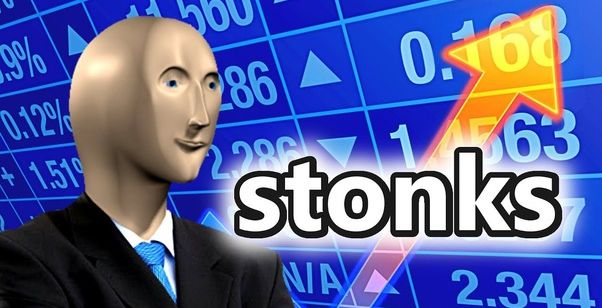

I don't think this competition is about time-serie forecasting, but more about building smart strategies. 

In this notebook, I introduce one strategy that I was exploring, where the idea is to buy in a given period P always the same stocks, selected based on their probability to outperform the market globaly. 

You will find in the notebook a bit of data exploration related to this idea, the way I processed the target data and the way I backtest the model trying to avoid as much as possible to leak an information that could compromise the accuracy of my results.

Also I am comparing my backtest on a large historical window vs the curernt window used in the LB, the idea being to be very cautious regarding LB results, taken from a very particular period as the market is currently affected by the war in Ukraine.

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import plotly.graph_objects as go

# I. Data Exploration


In [ ]:
stocks = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')
stocks['ExpectedDividend'] = stocks['ExpectedDividend']
stocks.Date = pd.to_datetime(stocks.Date)
stocks.Target = stocks.Target.fillna(0)

stocks.head()

We are interested in this notebook only in fluctuations of the Target over time. 

The data can be reshaped easily to seperate the differents stocks using the pivot function.

In [ ]:
stockspivot = pd.pivot(stocks, index = 'Date', values = 'Target', columns = 'SecuritiesCode')
stockspivot = stockspivot.ffill().fillna(0)
stockspivot.index = pd.to_datetime(stockspivot.index)

stockspivot.head()

Based on past obeservations, we are going to try to detect futur "top" performers.
In our strategy, we are going to estimate the probability of a stock to be a top performer for the coming periods, and long them during the whole period.

In [ ]:
decision_date = '2021-02-01'
window = 30


observations = stockspivot.loc[:decision_date].iloc[-2-window:]
futurforecast = stockspivot.loc[decision_date:].iloc[:window].cumsum()

good_stocks = futurforecast.iloc[-1].sort_values().index[-5:][::-1]

for i, stock_viz in enumerate(good_stocks):
    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            x = observations.index,
            y = observations[stock_viz].values,
            marker = {'color':'black'},
            showlegend = False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x = futurforecast.index,
            y = futurforecast[stock_viz].values,
            marker = {'color':'green'},
            showlegend=False,
            mode = 'lines'
        )
    )

    fig.add_trace(
        go.Scatter(
            x = [decision_date, decision_date],
            y = [min(observations[stock_viz].min(),futurforecast[stock_viz].min() ),
                 max(observations[stock_viz].max(),futurforecast[stock_viz].max())],
            marker = {'color':'red'},
            mode = 'lines',
            showlegend=False
        )
    )

    fig.update_layout(template = 'presentation', title = f'Top {i+1} stock on the 30 days from {decision_date}', height = 300) 
    fig.show()

Lets also visualise the top 20 performers on the period vs the bottom 20...
I am using this time a cumul viz for the past feature for the sake of visualisation

In [ ]:
observations = stockspivot.loc[:decision_date].iloc[-2-window:].cumsum()
futurforecast = stockspivot.loc[decision_date:].iloc[:window].cumsum()

good_stocks = futurforecast.iloc[-1].sort_values().index[-20:][::-1]
bad_stocks = futurforecast.iloc[-1].sort_values().index[:20][::-1]

fig = go.Figure()
for i, stock_viz in enumerate(good_stocks):
  
    fig.add_trace(
        go.Scatter(
            x = observations.index,
            y = observations[stock_viz].values,
            marker = {'color':'green'},
            showlegend = False,
            mode = 'lines',
            opacity = 0.2
        )
    )

    fig.add_trace(
        go.Scatter(
            x = futurforecast.index,
            y = futurforecast[stock_viz].values,
            marker = {'color':'green'},
            showlegend=False,
            mode = 'lines',
            opacity = 0.2
        )
    )
    
for i, stock_viz in enumerate(bad_stocks):

    fig.add_trace(
        go.Scatter(
            x = observations.index,
            y = observations[stock_viz].values,
            marker = {'color':'red'},
            showlegend = False,
            mode = 'lines',
            opacity = 0.2
        )
    )

    fig.add_trace(
        go.Scatter(
            x = futurforecast.index,
            y = futurforecast[stock_viz].values,
            marker = {'color':'red'},
            showlegend=False,
            mode = 'lines',
            opacity = 0.2
        )
    )



fig.update_layout(template = 'presentation', title = f'Parallele plot, top vs bottom performers on the period', height = 400) 
fig.show()

# II. Data Preparation and model training

We are going to use a simple boosting algorithm in this notebook, the purpose being not to reaching the best performances, but showing the concept.

In [ ]:
def gen_X(p1, time_horizon, test_horizon,goods = 200):
    
    '''The purpose of this function is to generate features and targets used for the training of the model
    The features X are the time_horizon last dates available from the moment we start to trade
    the features y is 1 if the stock is detected as a futur top performer on the next time_horizon, overwise 0
    
    '''

    p1 = pd.to_datetime(p1)
    subtrain = stockspivot.loc[:p1].iloc[-time_horizon-2:-2]
    subtest = stockspivot.loc[p1:].iloc[:test_horizon]
    subcum = subtest.cumsum()
    tt = subcum.iloc[-1].sort_values()
    g = tt.iloc[-goods:].index
    y = [1 if e in g else 0 for e in subtest.T.index]
    X = subtrain.T
    last_date = subtest.index[-1]
    return X,y,last_date

In order to make sure we are not introducing any leakage from the future, we are going to train the model from 2017 to 2019 and backtest from 2019+

In [ ]:
goods = 200
time_horizon = 10
test_horizon = 10
offset = 10

start_date = stockspivot.index[time_horizon+2]
start_test = pd.to_datetime('2019-01-01')
end_test = '2021-12-01'
p1 = start_date
Xtrain, ytrain = [], []
Xtest, ytest = [], []

# prepare training features
while True:
    
    X1,y1, pf = gen_X(p1, time_horizon,test_horizon,goods)
    p2 = pf+pd.offsets.Day(1)

    if pf>=start_test:
        break
        
    Xtrain.append(X1)
    ytrain.append(y1)
    
    p1 = p1 + pd.offsets.Day(offset)
    
Xtrain = np.vstack(Xtrain)
ytrain = np.hstack(ytrain)

Lets visualie our feature vectors as well as the associated label

In [ ]:
print(f'Feature vector 0: {Xtrain[0]}')
print(f'Corresponding label: {ytrain[0]}')

print(f'Feature vector 0: {Xtrain[1]}')
print(f'Corresponding label: {ytrain[1]}')

In [ ]:
model = LGBMClassifier(num_leaves=25, n_estimators=100)
model.fit(Xtrain, ytrain)
print(f'auc_score on train: {round(roc_auc_score(ytrain, model.predict_proba(Xtrain)[:,1]),3)}')
print(f'Last date available in the training set: {p1}')

# III. Model Evaluation

We used the period of 2017-2018 to train the model, to avoid futur leakage, we are not going to train the model on more data. 

### Benchmark

To evaluate our model, we are using a benchmark target, which is the return on the average indice. We can compute it easily on the period of interest.

In [ ]:
benchmark = stockspivot[start_test: end_test].mean(axis=1)
print(f'Sharp ratio of benchmark {np.round(benchmark.mean()/benchmark.std(),3)}')

fig = go.Figure(
    go.Scatter(
        x = benchmark.index,
        y = benchmark.cumsum(),
        marker = {'color':'black'}
    )
)

fig.update_layout(template = 'presentation', title = 'cumulative return of benchmark strategy', height = 350)
fig.show()

## Model return calculation

Starting from our first evaluation date, we apply the ML model to the past targets to select the 200 most likely stocks to perform well in the coming period and long those stocks during the whole period. At the end of the period, we reevaluate stocks and change the strategy accordingly

In [ ]:
test = []

while True:
    #Create the feature vector of past observations
    X = stockspivot.loc[:start_test].iloc[-time_horizon-2:-2].T
    
    #Slice the matrice of variations on the trading window we are currently interested in
    futur_variation = stockspivot.loc[start_test:].iloc[:test_horizon]
    
    #Make predictions, sort them, and keep promising stocks only on the period
    p = pd.Series(model.predict_proba(X)[:,1],index = X.index)
    longs = futur_variation.loc[:,p.sort_values().index[-200:]]

    #Apply the linear weights from rank 1 to rank 200 with the scale 2:1
    longs=longs*pd.Series(np.arange(200)/199+1, index=longs.columns)

    #Average the prediction on the 200 stocks (ponderated by the linear scaling)
    #Add the predictions to our list of predictions
    test.append((longs.sum(axis=1))/300)

    #Shift the data to go to next period until we reach the limit wanted
    start_test = futur_variation.index[-1]+pd.offsets.Day(1)
    if start_test>pd.to_datetime(end_test):
        break
        
test_results = pd.concat(test)

In [ ]:
print(f'Sharp ratio of benchmark {np.round(benchmark.mean()/benchmark.std(),3)}')
print(f'Sharp ratio of our model {np.round(test_results.mean()/test_results.std(),3)}')
fig = go.Figure(
    go.Scatter(
        x = benchmark.index,
        y = benchmark.cumsum(),
        marker = {'color':'black'},
        name = 'benchmark'
    )
)

fig.add_trace(
    go.Scatter(
        x = test_results.index,
        y = test_results.cumsum(),
        marker = {'color':'green'},
        name = 'predictions'
    )
)

fig.update_layout(template = 'presentation', title = 'cumulative return benchmark vs predictions', height = 350)
fig.show()

### Return during the public LB evaluation period

The data from the public LB is available, it is then possible to check our model vs the benchmark during that period also.

In [ ]:
sup_data = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv')
sup_data.Date = pd.to_datetime(sup_data.Date)
sup_data.Target = sup_data.Target.fillna(0)

sup_data = pd.pivot(sup_data, index = 'Date', values = 'Target', columns = 'SecuritiesCode')
sup_data = sup_data.fillna(0)
sup_data.index = pd.to_datetime(sup_data.index)
sup_data = pd.concat([stockspivot,sup_data])

start_test = '2021-12-01'
end_test = '2022-02-27'
benchmark = sup_data[start_test: end_test].mean(axis=1)

test = []

while True:
    #Create the feature vector of past observations
    X = sup_data.loc[:start_test].iloc[-time_horizon-2:-2].T
    
    #Slice the matrice of variations on the trading window we are currently interested in
    futur_variation = sup_data.loc[start_test:].iloc[:test_horizon]
    
    #Make predictions, sort them, and keep promising stocks only on the period
    p = pd.Series(model.predict_proba(X)[:,1],index = X.index)
    longs = futur_variation.loc[:,p.sort_values().index[-200:]]

    #Apply the linear weights from rank 1 to rank 200 with the scale 2:1
    longs=longs*pd.Series(np.arange(200)/199+1, index=longs.columns)

    #Average the prediction on the 200 stocks (ponderated by the linear scaling)
    #Add the predictions to our list of predictions
    test.append((longs.sum(axis=1))/300)

    #Shift the data to go to next period until we reach the limit wanted
    start_test = futur_variation.index[-1]+pd.offsets.Day(1)
    if start_test>pd.to_datetime(end_test):
        break
        
test_results = pd.concat(test)

print(f'Sharp ratio of benchmark {np.round(benchmark.mean()/benchmark.std(),3)}')
print(f'Sharp ratio of our model {np.round(test_results.mean()/test_results.std(),3)}')
fig = go.Figure(
    go.Scatter(
        x = benchmark.index,
        y = benchmark.cumsum(),
        marker = {'color':'black'},
        name = 'benchmark'
    )
)

fig.add_trace(
    go.Scatter(
        x = test_results.index,
        y = test_results.cumsum(),
        marker = {'color':'green'},
        name = 'predictions'
    )
)

fig.update_layout(template = 'presentation', title = 'cumulative return benchmark vs predictions', height = 350)
fig.show()

## Adding scrapped data on the remaining window

I created another notebook to pull more recent data using the lib yfinance, and check the current trend in the market. It is public and can be used to extand the evaluation of models.

In [ ]:
scrap_data = pd.read_csv('../input/jpx-extended-dataset-with-yfinance/jpx_extended_stocks.csv')
scrap_data.Date = pd.to_datetime(scrap_data["Date"])
scrap_data = pd.pivot(scrap_data, index = 'Date', values = 'Target', columns = 'SecuritiesCode')
scrap_data = scrap_data.loc[sup_data.index[-1]+pd.offsets.Day(1):].iloc[:-2]
scrap_data = scrap_data.fillna(0)
scrap_data = pd.concat([sup_data, scrap_data])
scrap_data.index = pd.to_datetime(scrap_data.index)

start_test = '2019-01-01'
end_test = '2022-04-10'
benchmark = scrap_data[start_test: end_test].mean(axis=1)

test = []

while True:
    #Create the feature vector of past observations
    X = scrap_data.loc[:start_test].iloc[-time_horizon-2:-2].T
    
    #Slice the matrice of variations on the trading window we are currently interested in
    futur_variation = scrap_data.loc[start_test:].iloc[:test_horizon]
    
    #Make predictions, sort them, and keep promising stocks only on the period
    p = pd.Series(model.predict_proba(X)[:,1],index = X.index)
    longs = futur_variation.loc[:,p.sort_values().index[-200:]]

    #Apply the linear weights from rank 1 to rank 200 with the scale 2:1
    longs=longs*pd.Series(np.arange(200)/199+1, index=longs.columns)

    #Average the prediction on the 200 stocks (ponderated by the linear scaling)
    #Add the predictions to our list of predictions
    test.append((longs.sum(axis=1))/300)

    #Shift the data to go to next period until we reach the limit wanted
    start_test = futur_variation.index[-1]+pd.offsets.Day(1)
    if start_test>pd.to_datetime(end_test):
        break
        
test_results = pd.concat(test)

print(f'Sharp ratio of benchmark {np.round(benchmark.mean()/benchmark.std(),3)}')
print(f'Sharp ratio of our model {np.round(test_results.mean()/test_results.std(),3)}')
fig = go.Figure(
    go.Scatter(
        x = benchmark.index,
        y = benchmark.cumsum(),
        marker = {'color':'black'},
        name = 'benchmark'
    )
)

fig.add_trace(
    go.Scatter(
        x = test_results.index,
        y = test_results.cumsum(),
        marker = {'color':'green'},
        name = 'predictions'
    )
)

fig.update_layout(template = 'presentation', title = 'cumulative return benchmark vs predictions', height = 350)
fig.show()

## Introducing rolling sharp

The current LB is evaluated on a 3 month window. Instead of measuring the sharp ratio on the whole predictions, we can also evaluate it on a rolling window, which will give insights about its stability over time

In [ ]:
start_test = '2019-01-01'
end_test = '2022-04-10'
benchmark = scrap_data[start_test: end_test].mean(axis=1)

while True:
    #Create the feature vector of past observations
    X = scrap_data.loc[:start_test].iloc[-time_horizon-2:-2].T
    
    #Slice the matrice of variations on the trading window we are currently interested in
    futur_variation = scrap_data.loc[start_test:].iloc[:test_horizon]
    
    #Make predictions, sort them, and keep promising stocks only on the period
    p = pd.Series(model.predict_proba(X)[:,1],index = X.index)
    longs = futur_variation.loc[:,p.sort_values().index[-200:]]

    #Apply the linear weights from rank 1 to rank 200 with the scale 2:1
    longs=longs*pd.Series(np.arange(200)/199+1, index=longs.columns)

    #Average the prediction on the 200 stocks (ponderated by the linear scaling)
    #Add the predictions to our list of predictions
    test.append((longs.sum(axis=1))/300)

    #Shift the data to go to next period until we reach the limit wanted
    start_test = futur_variation.index[-1]+pd.offsets.Day(1)
    if start_test>pd.to_datetime(end_test):
        break
        
test_results = pd.concat(test)
rolling_sharp = (test_results.rolling(90).mean()/test_results.rolling(90).std()).dropna()
rolling_sharp.name = 'sharp ratio'
rolling_sharp = rolling_sharp.sort_index()
fig = go.Figure(
    go.Scatter(
        x = rolling_sharp.index,
        y = rolling_sharp.values,
        name = "3 months average"
    )
)

fig.add_trace(
    go.Scatter(
        x = rolling_sharp.index,
        y = np.ones(len(rolling_sharp))*0.12,
        marker = {"color":"red"},
        name = "good limit"
    )
)

fig.update_layout(template='presentation', title = '3 months rolling sharp ratio')
fig.show()

In [ ]:
import plotly.express as px

print(f'Mean rolling sharp ratio {round(rolling_sharp.mean(),3)}')
print(f'Std rolling sharp ratio {round(rolling_sharp.std(),3)}')
fig = px.histogram(rolling_sharp, nbins = 100)
fig.update_layout(template = 'presentation', title = 'Rolling sharp distribution')
fig.show()

# Conclusion

I exposed here a possible strategy to use to determine stocks to buy during a given period. 
Even if the period seems efficient during bull markets, its performance becomes very bad during bear market or periods full of uncertainty such as the current war in Ukraine. 

It is interesting to note that the current period use for the benchmark is very specific (War in Ukraine), and we should be very carefull about not overfitting on the public LB only. 

Note: I didnt include in this model shorts as in the competition evaluation, as the proposed methodology doesn't show results on bottom-performers. I am still publishing this notebook as it highlights interesting findings.